### Example, full version steel data, version 3 + weather data

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik import resources, report
import phik

# from phik.report import plot_correlation_matrix

# replace this with your own file path in your own file system
path = "../data/sulatto_fulldata2025_version2.csv"
df = pd.read_csv(path, delimiter=";")

C:\Users\Nihar Buha\AppData\Local\Temp\ipykernel_25400\2829613844.py:12: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter=";")


In [51]:
# load the weather data that matches partially with our steel data (originally FMI)
df_weather = pd.read_csv("../tornio_weather.csv")

In [52]:
df.describe()

,Weight,Width,Seg No,CCM.TD. Heat counter Value,CCM.TD. Temperature liquidus Value,CCM.TD. Temperature liquidus Dynaphase Value,CCM.TD. Superheat Value,CCM.TD. Temperature tundish Value,CCM.SEN. Immersion depth Value,CCM.MD. Mold width Value,CCM.SLAB. Slab counter heat Value,CCM.SLAB. Slab counter sequence Value,HeatNo_in_Cast,CastNo
count,677815.000000,677815.000000,677815.000000,677299.000000,677299.0,677299.000000,677299.000000,677299.000000,677299.000000,677299.000000,674264.000000,674496.000000,677815.000000,671826.000000
mean,23864.551870,1388.799020,55.634902,4.230857,1455.0,1458.794001,37.868677,1492.868677,180.253312,1388.580491,3.602762,23.412446,3853.831222,175.767377
std,3581.849791,151.115179,32.787337,2.264734,0.0,1.703725,8.310765,8.310765,14.401174,151.113934,1.830274,14.367370,2041.101896,42.724486
min,6700.000000,1034.000000,1.000000,1.000000,1455.0,1452.000000,-3.000000,1452.000000,0.000000,1034.000000,1.000000,1.000000,315.000000,100.000000
25%,23218.000000,1284.000000,28.000000,2.000000,1455.0,1458.000000,34.000000,1489.000000,170.000000,1284.000000,2.000000,11.000000,2079.000000,140.000000
50%,23280.000000,1284.000000,55.000000,4.000000,1455.0,1459.000000,38.000000,1493.000000,182.000000,1284.000000,4.000000,22.000000,3878.000000,178.000000
75%,25795.000000,1543.000000,83.000000,6.000000,1455.0,1460.000000,42.000000,1497.000000,190.000000,1543.000000,5.000000,35.000000,5607.000000,212.000000
max,123605.000000,1620.000000,511.000000,10.000000,1455.0,1461.000000,145.000000,1600.000000,204.000000,1620.000000,9.000000,64.000000,7385.000000,248.000000


### Merging: Combine Steel data with weather data

#### Before we merge these datasets, we have to match their style of datetimes, which will be then used as the basis of merging (connecting point)

In [53]:
# Step 1: remove the seconds from the steel data
# Steel data: 2023-02-20 20:56:00
# Weather data: year, month, day separately + time : 00:30 (ten minute intervals)

# remove the the seconds (2 numbers + ":")
df['End time'] = df['End time'].str[:-3]

# seems to work! steel data datetime is now e.g. 2023-02-06 01:05

In [54]:
df_weather.columns

Index(['Observation station', 'Year', 'Month', 'Day', 'Time [Local time]',
       'Air temperature mean [°C]', 'Dew-point temperature mean [°C]',
       'Cloud cover [1/8]', 'Air pressure mean [hPa]',
       'Relative humidity mean [%]', 'Precipitation amount mean [mm]',
       'Weather description', 'Horizontal visibility mean [m]'],
      dtype='object')

In [55]:
# Step 2: combine all weather time information into a new variable => End time (same as in steel data)
df_weather['End time'] = df_weather['Year'].astype(str) + "-" + \
                         df_weather['Month'].astype(str).str.zfill(2) + "-" + \
                         df_weather['Day'].astype(str).str.zfill(2) + " " + \
                         df_weather['Time [Local time]'].astype(str)

In [56]:
# logic of the astype(str).str above:
# df_weather['Month'].astype(str) => convert this column into string
# df_weather['Month'].str.zfill(2) => use Python's string -functions (str) -> zfill

In [57]:
# for comparison, steel data has the time: 2023-02-06 01:05
df_weather.head(3)['End time']

0    2023-01-01 00:00
1    2023-01-01 00:10
2    2023-01-01 00:20
Name: End time, dtype: object

In [58]:
# Final step before merging: ROUND THE STEEL DATA minutes into the nearest tens of minutes
# basically we can make a function for pandas to fix this
# the idea: get the minutes from the time
# => round the minutes to nearest 10
# => convert minutes back to string => combine with the original time
def fix_date(row):
    date = row['End time']

    # extract te minutes only from the date
    minutes = int(date[-2:])

    # round the minutes to the nearest ten (by using negative round decimal amount)
    minutes = round(minutes, -1)

    # rebuild the date string
    # date[0:-2] => everything else except the minutes
    result = date[0:-2] + str(minutes).zfill(2)
    return result

# apply the function and check results
df['End time'] = df.apply(fix_date, axis=1)

In [59]:
# take a random sample to see if all time stamps
# are in the tens of minutes
df['End time'].sample(5)

155778    2023-03-01 02:30
185       2023-02-06 01:20
270799    2023-03-15 02:60
294782    2023-03-18 11:10
420804    2023-03-31 20:10
Name: End time, dtype: object

#### Now we can proceed with merging the steel data and the weather


In [60]:
# sanity check, how much data we have BEFORE MERGING
# after merging, we should have exactly same amount of data in the end
len(df)

677815

In [61]:
# merge data (very similar to SQL joins)
df = df.merge(df_weather, left_on="End time", right_on="End time", how="left")

In [62]:
# sanity check 2 => do we still have exactly same amount of data?
len(df)

677815

In [63]:
# we no longer need the original weather data time columns (since we have the End time)
df = df.drop(['Year', 'Month', 'Day', 'Time [Local time]',], axis=1)

In [64]:
len(df.columns)

53

#### Proceed normally with fixing the steel data column format etc. as in previous examples

In [65]:
# let's collect all numeric columns that need their commas converted to period => float number
fixables = ["Length", 
            "Thickness",
            'CCM.TD. Steel weight in tundish Value',
            'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
            'CCM.TD. Stopper position max Value',
            'CCM.TD. Stopper position min Value',
            'CCM.TD. Stopper pos chg max segment Value',
            'CCM.TD. Stopper position chg 10 s Value',
            'CCM.TD. Stopper position slab chg Value', 
            'CCM.MD. Level average Value',
            'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
            'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
            'CCM.MIX. Concentration factor Value',
            'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value'
            ]

# brute force and change datatype for each of thecolumns
for column_name in fixables:
    df[column_name] = df[column_name].astype(str).replace(regex=",", value=".")
    df[column_name] = df[column_name].astype(float)

In [66]:
df = df.replace("-", np.nan)

In [67]:
# import dtale

# the data is now different, instead of Material Name for being a unique identifier 

# we have Cast -> Heat -> Slab -> Seg No
# One Cast usually provides ~4-8 amount of Heats, one heat usually provides 5-8 slabs
# filter_df = df[['CastNo', 'HeatNo_in_Cast', 'SlabNo_in_Heat', 'Seg No', 'CCM.TD. Steel weight in tundish Value']]
# dtale.show(filter_df).open_browser()

## Before we filter only one cast/heat/slab (whatever the level), we have to process and combine the cast/heat/slab -numbers

In [68]:
df['CastNo'].unique()

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199., 200., 201., 202., 203., 204., 205., 206., 207., 208., 209.,
       210., 211., 212., 213., 214., 215., 216., 217., 218., 219., 220.,
       221., 222., 223., 224., 225., 226., 227., 228., 229., 230., 231.,
       232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242.,
       243., 244., 245., 246., 247., 248.,  nan])

### THIS IS THE PART WHERE YOU CAN CHANGE THE ACTIVE CAST VISUALIZED

In [69]:
# filter out only one cast at a time
# because there's too much data to visualize otherwise
selected_id = 141
df_single = df[df['CastNo'] == selected_id]
df_part = df[df['CastNo'] == selected_id]


df_single.head(3)

,Material Type,End time,Route,Weight,Length,Thickness,Width,Grade,Quality Status,Seg No,...,CastNo,Observation station,Air temperature mean [°C],Dew-point temperature mean [°C],Cloud cover [1/8],Air pressure mean [hPa],Relative humidity mean [%],Precipitation amount mean [mm],Weather description,Horizontal visibility mean [m]
172640,slab,2023-03-04 16:30,Route 1,23207,11.21,202.0,1316,720-A,ERROR,1,...,141.0,Tornio Torppi,-0.3,-6,Mostly cloudy (7/8),997.5,66,0,No significant weather,50000
172641,slab,2023-03-04 16:30,Route 1,23207,11.21,202.0,1316,720-A,ERROR,2,...,141.0,Tornio Torppi,-0.3,-6,Mostly cloudy (7/8),997.5,66,0,No significant weather,50000
172642,slab,2023-03-04 16:30,Route 1,23207,11.21,202.0,1316,720-A,ERROR,3,...,141.0,Tornio Torppi,-0.3,-6,Mostly cloudy (7/8),997.5,66,0,No significant weather,50000


In [70]:
# for easier manipulation in future, we're going to replace the heat numbers with a more simple system
# so instead of 2205, 2170 .... we'll replace them with 1, 2, 3, 4 etc.

unique_heats = list(df_single['HeatNo_in_Cast'].unique())

# this one seems to have 4 heats (cast with id 125)
unique_heats

[np.int64(2548),
 np.int64(770),
 np.int64(6272),
 np.int64(4767),
 np.int64(1239),
 np.int64(5411),
 np.int64(3976),
 np.int64(1862)]

In [71]:
# let's go through the four heat numbers
# and collect them into a dictionary
replacement_dict = {}

for heat in unique_heats:
    index = unique_heats.index(heat)
    replacement_dict[heat] = index + 1

replacement_dict
df_single['HeatNo_in_Cast'] = df_single['HeatNo_in_Cast'].map(replacement_dict)

C:\Users\Nihar Buha\AppData\Local\Temp\ipykernel_25400\3870752511.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['HeatNo_in_Cast'] = df_single['HeatNo_in_Cast'].map(replacement_dict)


In [72]:
# seems to work!
df_single['HeatNo_in_Cast'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8])

#### Sine we don't have Material Name (one id only) anymore, let's combine Cast -> Heat -> Slab -> Seg No into one single identifier

In [73]:
df_single['ProcessNo'] = df_single['HeatNo_in_Cast'].astype(str) + \
                         df_single['SlabNo_in_Heat'].astype(str).str.zfill(2) + \
                         df_single['Seg No'].astype(str).str.zfill(2) 


# NOTE TO SELF! SlabNo_in_Heat can be A in some rare cases
# this probably is supposed to be number 10 according to hexadecimal
df_single = df_single.reset_index()
df_single['indexno'] = df_single.index + 1

C:\Users\Nihar Buha\AppData\Local\Temp\ipykernel_25400\3985312939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['ProcessNo'] = df_single['HeatNo_in_Cast'].astype(str) + \


In [74]:
# most probably a bug in matplotlib
# if you visualize data with mixed integers and floats
# the y-axis MIGHT be flipped (inverted)
df_single['Relative humidity mean [%]'] = df_single['Relative humidity mean [%]'].astype(float)
df_single['Air pressure mean [hPa]'] = df_single['Air pressure mean [hPa]'].astype(float)
df_single['Dew-point temperature mean [°C]'] = df_single['Dew-point temperature mean [°C]'].astype(float)


## From this point onward, we can just visualize as previously

In [75]:
# phik_matrix1 = df_single.phik_matrix()

# particular_col = ['CCM.SEN. SEN Type Value',  'CCM.TD. Stopper Type Value']

# phik_subset = phik_matrix1.loc[particular_col, particular_col]

In [76]:
# we are going to use multi-line charts + df.melt() to visualize the process better
# see "ricebeefcoffee_revisited.ipynb" from lecture 9 examples on how to work
# with multiline + df.melt()

# list all columns you want to see in the multiline chart
columns_all = [
       'Length', 'Thickness', 'Width', 'Seg No',
       'CCM.TD. Heat counter Value',
       'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Steel weight in tundish Value',
       'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
       'CCM.MD. Mold width Value', 'CCM.MIX. Concentration factor Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',
       'CCM.SLAB. Slab counter heat Value',
       'CCM.SLAB. Slab counter sequence Value',
       'CCM.SEN. SEN Type Value','CCM.TD. Stopper Type Value']

# here we make more specific set of columns for easier visualization

# IF WE TRY TO VISUALIZE ALL VARIABLES AT ONCE, we can see only straight
# lines because the chart has to zoom out too much

# group of columns with very high values
columns_high = ['CCM.MD. Level average Value', 'Air pressure mean [hPa]']

# group of columns with average value ranges 
columns_middle = ['CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Steel weight in tundish Value',
       'Relative humidity mean [%]']

# group of columns with small value ranges
columns_low = ['CCM.TD. Tundish inflow Value',
               'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value', 'CCM.MIX. Concentration factor Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',]


# even less columns in this version with small value ranges
columns_low2 = ['CCM.TD. Tundish inflow Value',
                'CCM.MD. Level std_dev Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value', 'Dew-point temperature mean [°C]']

columns_low3 = ['CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Steel weight in tundish Value',
       'CCM.STR. Throughput Value'
       ]

#### Create melt versions of some of the columns defined above

#### Plot the melt versions - multiline plot

# Perform normalization on this!!


In [77]:
df_single['Dew-point temperature mean [°C]'].min()


np.float64(-6.0)

In [78]:
df_single['Dew-point temperature mean [°C]'].max()

np.float64(-4.4)

In [79]:
# compare Casts 100, 125, 171 
# different stopper are in use, how does this correlate with the 
# phenomena we see in the data!
df['CCM.SEN. SEN Type Value'].value_counts()

CCM.SEN. SEN Type Value
Product 1    471397
Product 2    200963
Name: count, dtype: int64

In [80]:
# # Normalization
# scaler = StandardScaler()

columns_low3 = ['CCM.TD. Stopper Last Position Value',
                'Dew-point temperature mean [°C]',
    'CCM.TD. Steel weight in tundish Value',
    'CCM.STR. Throughput Value',
    'CCM.TD. Tundish inflow Value',
    'CCM.STR. Speed - Mold avg Value',
    'CCM.TD. Stopper position slab chg Value'
    ]

# df[columns_low3] = scaler.fit_transform(df[columns_low3])

In [81]:
target_variable = 'CCM.TD. Stopper position slab chg Value'

phik_matrix = df_single.phik_matrix()

available_other_variables = [var for var in columns_all if var in phik_matrix.columns]

if target_variable in phik_matrix.index:
    correlations = phik_matrix.loc[target_variable, available_other_variables]
    print(f"Phi-K correlations of '{target_variable}' with available variables:")
    print(correlations)
else:
    print(f"Error: Target variable '{target_variable}' not found in phik_matrix index.")


interval columns not set, guessing: ['index', 'Weight', 'Length', 'Thickness', 'Width', 'Seg No', 'CCM.TD. Heat counter Value', 'CCM.TD. Temperature liquidus Value', 'CCM.TD. Temperature liquidus Dynaphase Value', 'CCM.TD. Steel weight in tundish Value', 'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value', 'CCM.TD. Stopper position max Value', 'CCM.TD. Stopper position min Value', 'CCM.TD. Stopper pos chg max segment Value', 'CCM.TD. Stopper position chg 10 s Value', 'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value', 'CCM.TD. Temperature tundish Value', 'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value', 'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value', 'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value', 'CCM.MD. Mold width Value', 'CCM.MIX. Concentration factor Value', 'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value', 'CCM.SLAB. Slab counter heat Value', 'CCM.SLAB. Slab counter seq

c:\Users\Nihar Buha\OneDrive\Desktop\Semester project\Project-Data-Analytics-and-Visualization\.venv\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable ProcessNo is large: 5746. Are you sure this is not an interval variable? Analysis for pairs of variables including ProcessNo can be slow.
  warnings.warn(
c:\Users\Nihar Buha\OneDrive\Desktop\Semester project\Project-Data-Analytics-and-Visualization\.venv\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Thickness for analysis 1. Dropping this column
  warnings.warn(
c:\Users\Nihar Buha\OneDrive\Desktop\Semester project\Project-Data-Analytics-and-Visualization\.venv\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable CCM.TD. Temperature liquidus Value for analysis 1. Dropping this column
  warnings.warn(
c:\Users\Nihar Buha\OneDrive\Desktop\Semester project\Project-Data-Analytics-and-Visualization\.venv\lib\si

Phi-K correlations of 'CCM.TD. Stopper position slab chg Value' with available variables:
Length                                          0.287947
Width                                           0.456481
Seg No                                          0.000000
CCM.TD. Heat counter Value                      0.578121
CCM.TD. Temperature liquidus Dynaphase Value    0.085142
CCM.TD. Steel weight in tundish Value           0.603055
CCM.TD. Tundish inflow Value                    0.653322
CCM.TD. Stopper Last Position Value             0.605494
CCM.TD. Stopper position max Value              0.553932
CCM.TD. Stopper position min Value              0.664494
CCM.TD. Stopper pos chg max segment Value       0.812990
CCM.TD. Stopper position chg 10 s Value         0.921495
CCM.TD. Stopper position slab chg Value         1.000000
CCM.TD. Superheat Value                         0.522827
CCM.TD. Temperature tundish Value               0.522827
CCM.SEN. Immersion depth Value                  0.20809

In [82]:
# start_value = 1000
# end_value = 2000
# df = df[df['Seg No'] >= start_value]
# df = df[df['Seg No'] <= end_value]

In [83]:
# df['ProcessNo'] = df['CastNo'].astype(str) + \
df['ProcessNo'] =   df['HeatNo_in_Cast'].astype(str) + \
                        df['SlabNo_in_Heat'].astype(str).str.zfill(2) + \
                        df['Seg No'].astype(str).str.zfill(2)


df_melt_low3 = pd.melt(df, id_vars=["ProcessNo", "CastNo"], value_vars=columns_low3,
            var_name="Measurement", value_name="Value")

        # Normalizing variables to fit on the display
df_melt_low3.loc[df_melt_low3["Measurement"] == "CCM.TD. Steel weight in tundish Value", "Value"] /= 4
df_melt_low3.loc[df_melt_low3["Measurement"] == 'CCM.MD. Level change (max-min) Value', "Value"] /= 4
df_melt_low3.loc[df_melt_low3["Measurement"] == 'CCM.TD. Stopper Last Position Value', "Value"] /= 6

max_value = 10
df_melt_low3.loc[df_melt_low3["Measurement"] == "CCM.TD. Tundish inflow Value", "Value"] = np.minimum(
    df_melt_low3.loc[df_melt_low3["Measurement"] == "CCM.TD. Tundish inflow Value", "Value"], max_value
)



c:\Users\Nihar Buha\OneDrive\Desktop\Semester project\Project-Data-Analytics-and-Visualization\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
df['CCM.TD. Stopper Last Position Value'] = df['CCM.TD. Stopper Last Position Value'].astype(float)
df['Dew-point temperature mean [°C]'] = df['Dew-point temperature mean [°C]'].astype(float)

In [85]:
# This visualization has some outliers, so to make it easier to visualize, let's get rid of 
# some of those.
df_part = df_part[df_part['CCM.MD. Level change (max-min) Value'] < 20]
df_part = df_part[df_part['CCM.TD. Stopper position slab chg Value'] < 4.5]
df_part = df_part[df_part['CCM.MD. Level change (max-min) Value'] < 9]
df_part = df_part[df_part['CCM.TD. Stopper pos chg max segment Value'] < 4.5]

# A scatter plot that shows how the QUALITY STATUS SENSOR works.


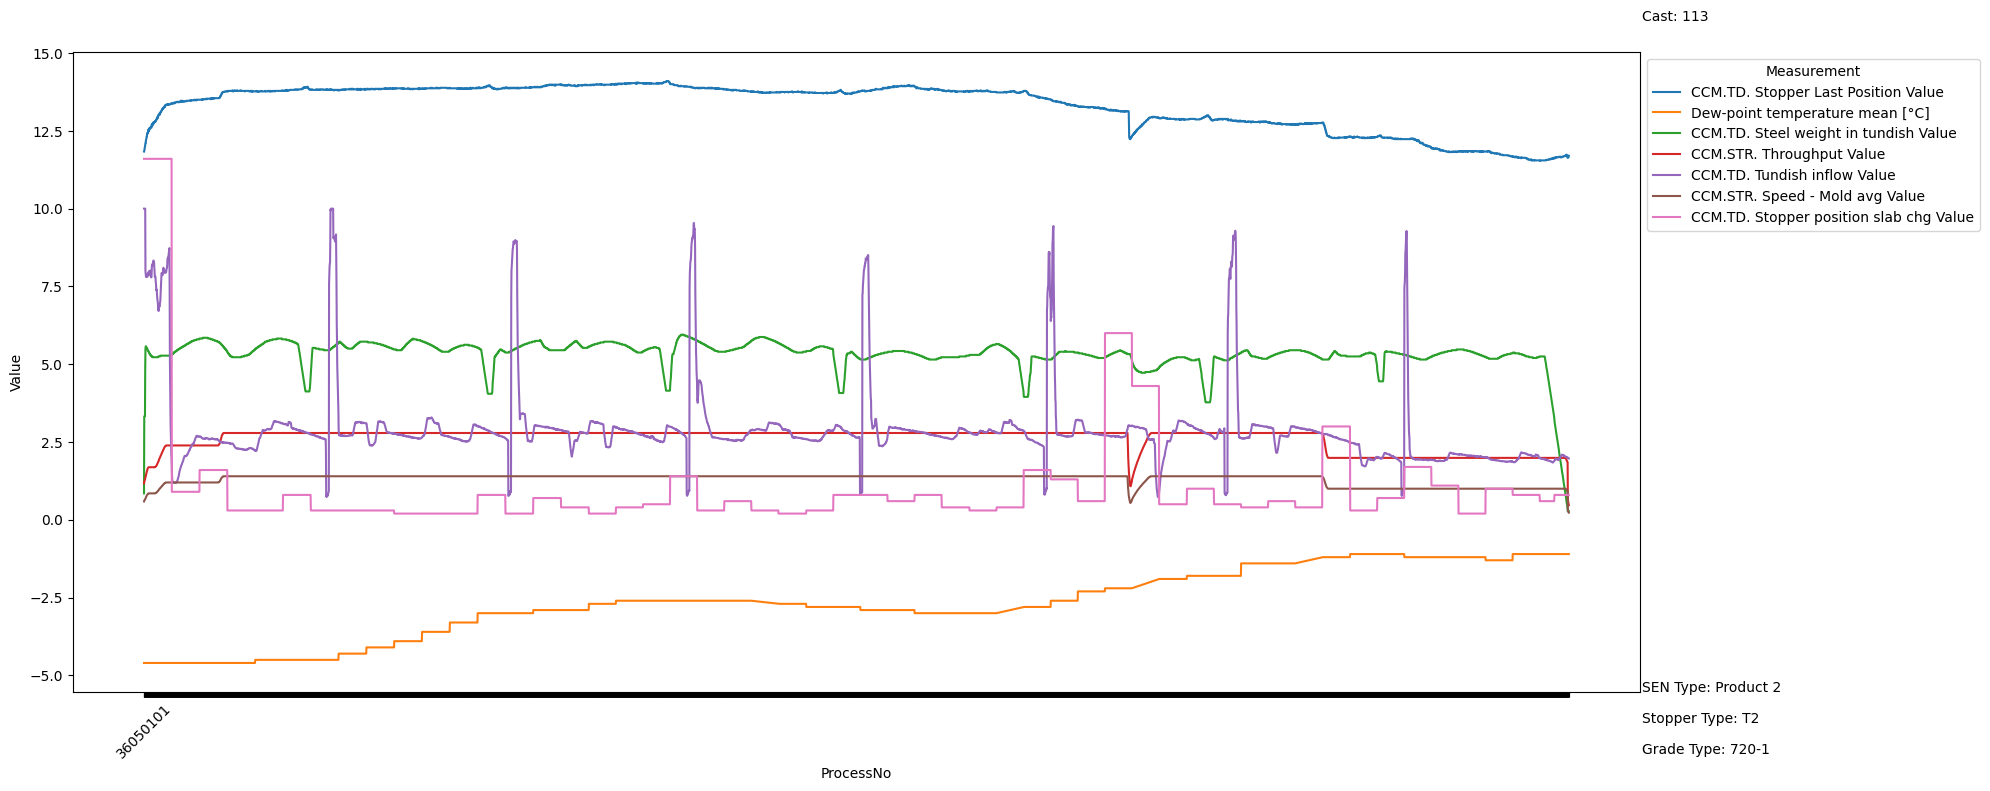

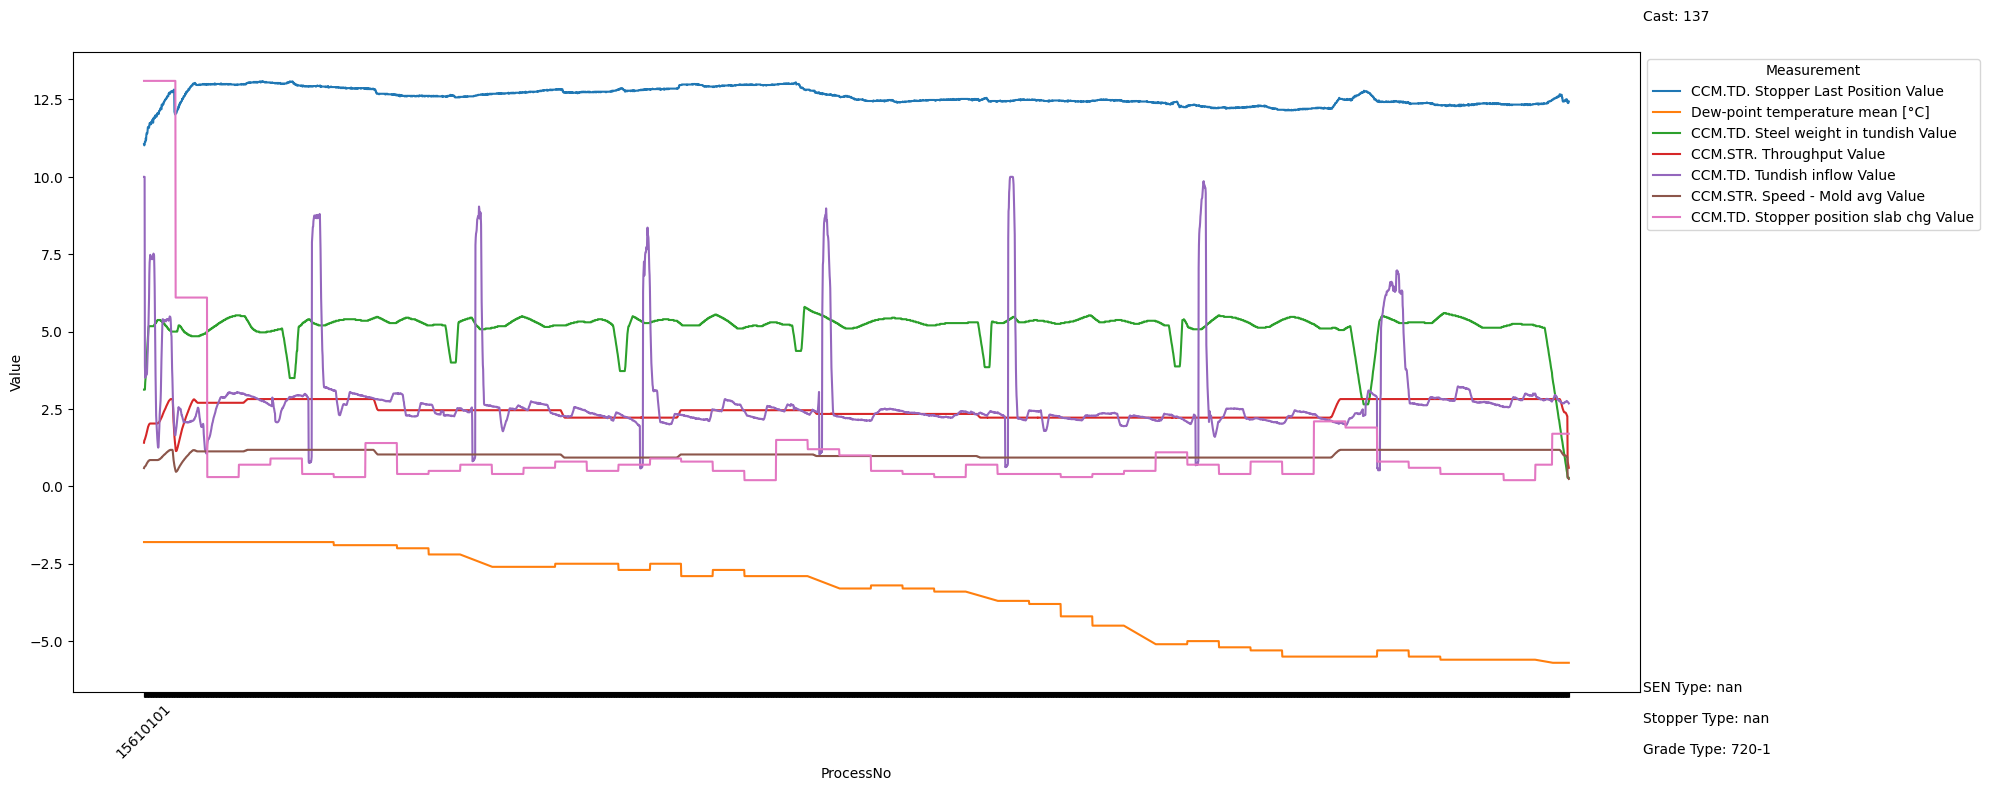

In [97]:
cast_list = [113, 137]

for i in cast_list:
    
#     if i == 150.:
#         break
    df_single1 = df_melt_low3[df_melt_low3['CastNo'] == i]
    sen_type  = df.loc[df['CastNo'] == i, 'CCM.SEN. SEN Type Value']
    sen_type = sen_type.values
    sen_type = sen_type[0]
    stopper_type = df.loc[df['CastNo'] == i, 'CCM.TD. Stopper Type Value']
    stopper_type = stopper_type.values
    stopper_type = stopper_type[0]
    grade_type = df.loc[df['CastNo'] == i, 'Grade']
    grade_type = grade_type.values
    grade_type = grade_type[0]

    fig, axes = plt.subplots(figsize=(20, 8))

    plot = sns.lineplot(data=df_single1, x="ProcessNo", y="Value", hue="Measurement", errorbar=None)
    
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))

    # reduce the number of x-labels
    n = len(df_single) / 20
    [l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

    plt.xticks(rotation=45);


    x_min, x_max = plot.get_xlim()
    y_min, y_max = plot.get_ylim()
    plot.invert_yaxis()



    plt.text(x_max + 10, y_min + 1, f'Cast: {i}')
    plt.text(x_max + 10,y_max,f"SEN Type: {sen_type}")
    plt.text(x_max + 10, y_max -1,f"Stopper Type: {stopper_type}")
    plt.text(x_max + 10, y_max -2,f"Grade Type: {grade_type}")

    plt.tight_layout()
    plt.show()



    # filename = os.path.join('graphs/low3_graphs', f'cast_{i}.png')

    # plt.savefig(filename)

    # plt.close()


        


In [87]:
# min_val = df_single['CCM.TD. Stopper position slab chg Value'].min()
# max_val = df_single['CCM.TD. Stopper position slab chg Value'].max()

# # Min-Max scaling to [0, 1]
# df_single['x_scaled_0_1'] = (df_single['CCM.TD. Stopper position slab chg Value'] - min_val) / (max_val - min_val)

# # Scale to the range [1, 4]
# new_min = 1
# new_max = 4
# df_single['x_compressed_1_4'] = df_single['x_scaled_0_1'] * (new_max - new_min) + new_min

# ff = sns.scatterplot(x='CCM.TD. Stopper position slab chg Value', y='CCM.TD. Stopper pos chg max segment Value', hue='Quality Status', data=df_single)

<Axes: xlabel='CCM.TD. Stopper position slab chg Value', ylabel='CCM.MD. Level change (max-min) Value'>

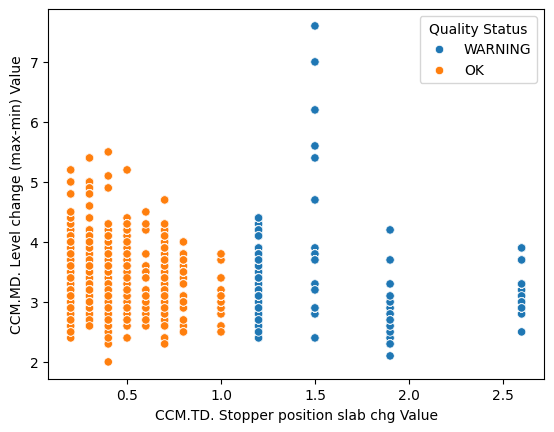

In [88]:
sns.scatterplot(df_part, x='CCM.TD. Stopper position slab chg Value', y='CCM.MD. Level change (max-min) Value', hue='Quality Status')

<Axes: xlabel='Quality Status', ylabel='count'>

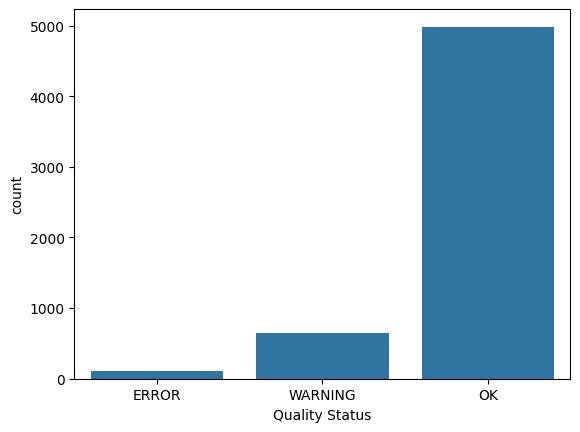

In [89]:

sns.countplot(x='Quality Status', data=df_single)

In [90]:
grouped = df_single['CCM.STR. Throughput Value'].mean()

grouped = np.round(grouped, 2)

print(f"Average Throughput Value: {grouped}")

Average Throughput Value: 2.78


In [91]:
nn = df_single['CCM.TD. Stopper position slab chg Value'].mean()

nn = np.round(nn, 2)

print(f"Average Stopper's movement: {nn}")

Average Stopper's movement: 0.8


In [92]:
# dfstop1 = df[df['CCM.TD. Stopper Type Value'] == 'T1']
# dfstop2 = df[df['CCM.TD. Stopper Type Value'] == 'T2']
# dfsen1 = df[df['CCM.TD. Stopper Type Value'] == 'Product 1']
# dfsen2 = df[df['CCM.TD. Stopper Type Value'] == 'Product 2']

# phik1 = dfstop1.phik_matrix()


In [93]:
df

,Material Type,End time,Route,Weight,Length,Thickness,Width,Grade,Quality Status,Seg No,...,Observation station,Air temperature mean [°C],Dew-point temperature mean [°C],Cloud cover [1/8],Air pressure mean [hPa],Relative humidity mean [%],Precipitation amount mean [mm],Weather description,Horizontal visibility mean [m],ProcessNo
0,slab,2023-02-06 01:00,Route 1,25783,10.63,202.0,1539,720-1,ERROR,1,...,Tornio Torppi,-11.5,-12.8,Clear (0/8),1023.1,90,0,No significant weather,50000,28210101
1,slab,2023-02-06 01:00,Route 1,25783,10.63,202.0,1539,720-1,ERROR,2,...,Tornio Torppi,-11.5,-12.8,Clear (0/8),1023.1,90,0,No significant weather,50000,28210102
2,slab,2023-02-06 01:00,Route 1,25783,10.63,202.0,1539,720-1,ERROR,3,...,Tornio Torppi,-11.5,-12.8,Clear (0/8),1023.1,90,0,No significant weather,50000,28210103
3,slab,2023-02-06 01:00,Route 1,25783,10.63,202.0,1539,720-1,ERROR,4,...,Tornio Torppi,-11.5,-12.8,Clear (0/8),1023.1,90,0,No significant weather,50000,28210104
4,slab,2023-02-06 01:00,Route 1,25783,10.63,202.0,1539,720-1,ERROR,5,...,Tornio Torppi,-11.5,-12.8,Clear (0/8),1023.1,90,0,No significant weather,50000,28210105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677810,slab,2023-04-30 16:00,Route 1,13145,6.51,202.0,1284,720-1,ERROR,62,...,Tornio Torppi,4.2,2.4,Cloudy (8/8),1006,88,0,"Rain, light",19478,10500862
677811,slab,2023-04-30 16:00,Route 1,13145,6.51,202.0,1284,720-1,ERROR,63,...,Tornio Torppi,4.2,2.4,Cloudy (8/8),1006,88,0,"Rain, light",19478,10500863
677812,slab,2023-04-30 16:00,Route 1,13145,6.51,202.0,1284,720-1,ERROR,64,...,Tornio Torppi,4.2,2.4,Cloudy (8/8),1006,88,0,"Rain, light",19478,10500864
677813,slab,2023-04-30 16:00,Route 1,13145,6.51,202.0,1284,720-1,ERROR,65,...,Tornio Torppi,4.2,2.4,Cloudy (8/8),1006,88,0,"Rain, light",19478,10500865


In [94]:

 
dfstopper1bad = df["CastNo"].isin(cast_list)

# matrix = dfstopper1bad[['CCM.TD. Stopper position slab chg Value', 'CCM.SEN. SEN Type Value', 'Grade', 'CCM.TD. Steel weight in tundish Value']].phik_matrix()
# sns.heatmap(matrix, annot=True)

dfstopper1bad
 

0         False
1         False
2         False
3         False
4         False
          ...  
677810    False
677811    False
677812    False
677813    False
677814    False
Name: CastNo, Length: 677815, dtype: bool

In [95]:
SEN_1 = df[df['CCM.SEN. SEN Type Value'] == 'Product 1']
SEN_2 = df[df['CCM.SEN. SEN Type Value'] == 'Product 2']
# Check connection between grade of steel and sen type? (lurking vairable?)
groupby_1 = SEN_1.groupby(['Grade'])[['CCM.SEN. SEN Type Value']].count()
groupby_1 = pd.DataFrame(groupby_1)
groupby_1.rename(columns={'CCM.SEN. SEN Type Value': 'SEN Type 1 Count'}, inplace=True)
groupby_2 = SEN_2.groupby(['Grade'])[['CCM.SEN. SEN Type Value']].count()
groupby_2 = pd.DataFrame(groupby_2)
groupby_2.rename(columns={'CCM.SEN. SEN Type Value': 'SEN Type 2 Count'}, inplace=True)
 
 
# groupby_1['CCM.SEN. SEN Type Value'] = groupby_1['SEN Type 1 Count']
# groupby_2['CCM.SEN. SEN Type Value'] = groupby_1['SEN Type 2 Count']
 
result = pd.concat([groupby_1, groupby_2], axis=1)
result = result.reset_index()
 
 
# result = pd.melt(result, id_vars='Grade',
#         value_vars=['SEN Type 1 Count', 'SEN Type 2 Count'],
#         var_name='SEN Type', value_name='Count')
 
# result = result[result['Grade'] != '720-1']

result

 

,Grade,SEN Type 1 Count,SEN Type 2 Count
0,720-1,325824,140863.0
1,720-2,3221,1388.0
2,720-A,23756,5582.0
3,720-B,4716,1214.0
4,720-K,2028,NaN
5,724-1,1091,777.0
6,724-A,580,1195.0
7,725-1,39985,8145.0
8,725-2,4913,5262.0
9,725-8,8346,7758.0


ValueError: Could not interpret value `Count` for `y`. An entry with this name does not appear in `data`.

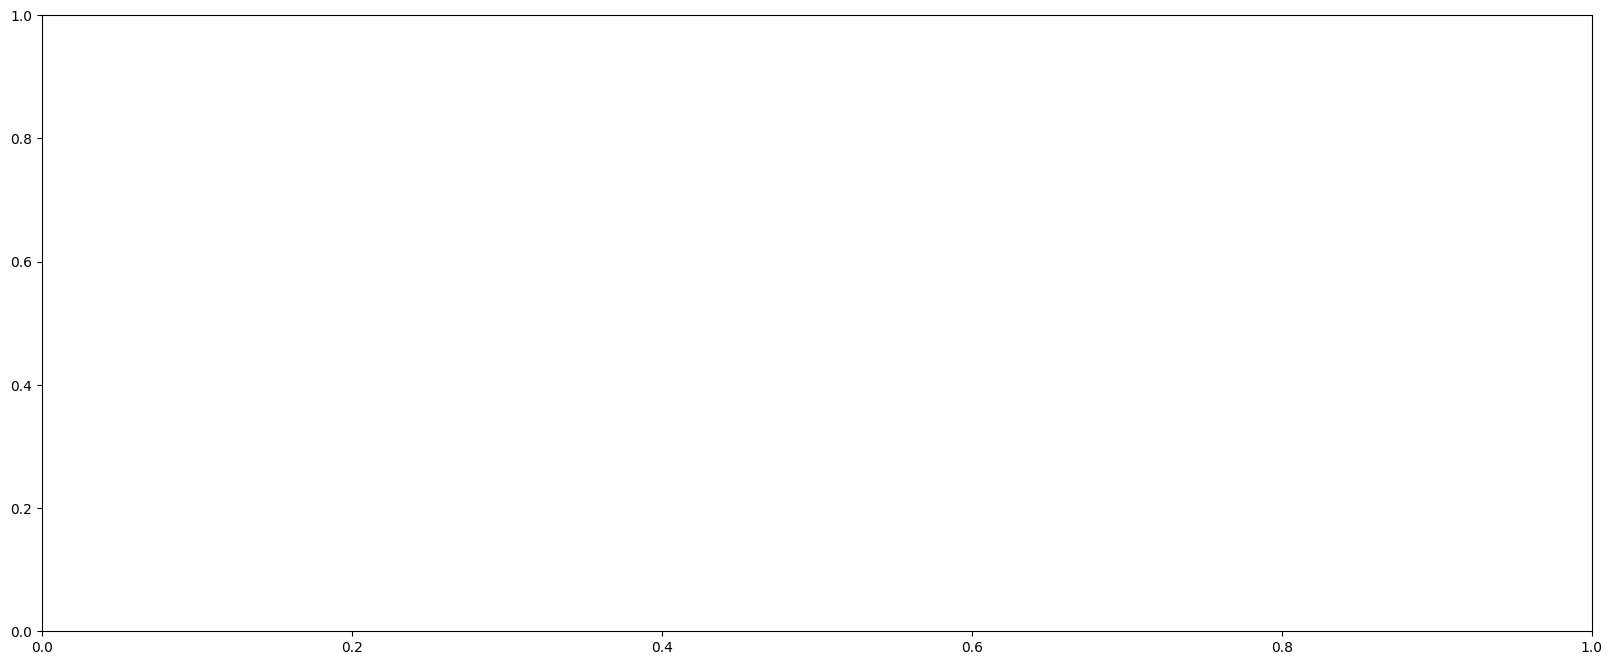

In [96]:
fig, axes = plt.subplots(figsize=(20, 8))
sns.barplot(x='Grade', y='Count', hue='SEN Type', data=result)

In [ ]:
groupby_grade = df.groupby(['Grade'])[['CCM.TD. Stopper position slab chg Value']].count()
# groupby_grade = pd.DataFrame(groupby_1)
groupby_grade

,CCM.TD. Stopper position slab chg Value
Grade,
720-1,470950
720-2,4609
720-A,29338
720-B,6606
720-K,2028
724-1,1868
724-A,1775
725-1,48130
725-2,10175


In [ ]:
# goodcasts_list = []
# badcasts_list = []
 
# for cast_id in range(99, 247):
#         df_single = df[df['CastNo'] == cast_id]
#         values = df_single['Quality Status'].value_counts()
#         print(f"CastNo {cast_id} Quality Status Counts:")
#         print(values)
#         badslabs = values.get(1, 0) + values.get(2, 0)
#         goodslabs = values.get(0, 0)
#         print(f'{badslabs} bad slabs, {goodslabs} good slabs')
#         if badslabs > goodslabs:
#                 print('Bad cast!')
#                 badcasts_list.append(cast_id)
#         else:
#                 print('Good cast!')
#                 goodcasts_list.append(cast_id)
 
 
# # print(f' Bad casts: {badcasts_list}')

In [ ]:
badcasts_list

[108, 112, 138]